<a href="https://colab.research.google.com/github/Clarke-Henshaw-Miles/extra/blob/master/DATA%20SCIENCE/Chapter7Attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To be completed at the Live Session and in your own time.

These set of examples we will help you get familiar with non parametric tests and correlations within a Jupyter notebook.   The questions coloured green are important practice for CA, particularly CA 2.

Before attempting these examples, please ensure you have read through [Chapter 7 Jupyter Notebook](https://github.com/haleygomez/Data-Science-2024/blob/main/blended_exercises/Chapter7/Chapter7.ipynb) and have completed the Learning Central **Chapter 7 quiz**.

***

# MCMC

## <font color=#30a64d>Question</font>

In Chapter 6, we saw that Professor Dumbledore, studying the extinction of dragons, discovers a new set of egg remnants in an unexplored valley in Madagascar. The remnants are radio carbon dated and found to have the following ages in years:

2141.22, 1781.15, 1523.37, 1816.90, 1932.29, 1541.21, 720.782, 1026.22, 1687.22, 2460.59

Professor Snape however did a previous study in the next valley where he found eggs that were on average 1200 years old, following a normal distribution with standard deviation of 300 years.

- Write an MCMC algorithm from scratch and use it to create a posterior distribution for the mean age of the eggs. What is the mean and variance for the posterior using your MCMC distribution?

- Check the MCMC has converged.

- How does this compare with the analytical values you derived in Chapter 6?

### Answer

So from Chapter 6 we already derived an analytical posterior with mean of 1568.73 +/ 150.56 year.

Now we do the same using MCMC.

MCMC gives the posterior dist for the mean age of the eggs by creating a large sample of $\theta$ and calculating the posterior for the sample.

The denominator (the evidence) is a constant for normalization and does not effect shape of dist so we can ignore it for now and only use the numerator (likelihood x prior).


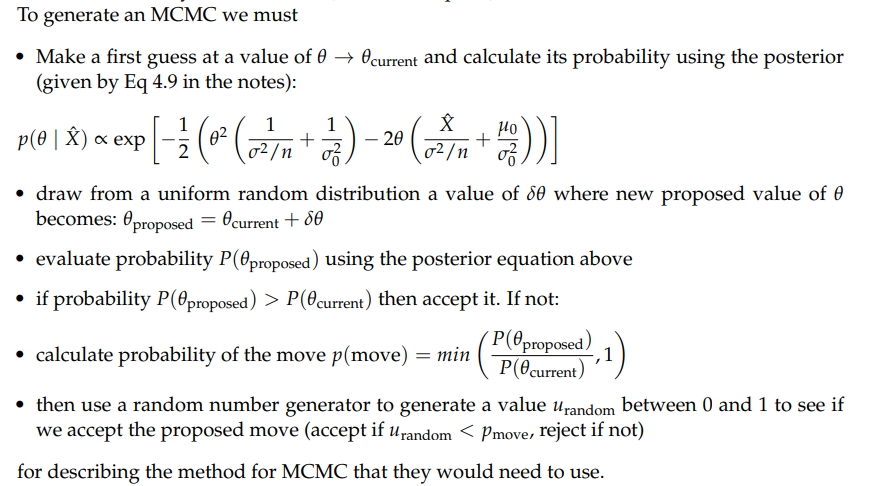

***